In [1]:
# Import the dependencies
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
from sqlalchemy import create_engine, inspect, text, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

In [2]:
# CONNECT TO POSTGRES
USERNAME = "postgres"
PASSWORD = "postgres"
HOST = "localhost"
PORT = 5432
DATABASE = "project02_crowdfunding_db"
connection_str = f"postgresql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"

# Create Engine
engine = create_engine(connection_str)

In [3]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

category
--------
category_id TEXT
category TEXT

subcategory
--------
subcategory_id TEXT
subcategory TEXT

contacts
--------
contact_id BIGINT
first_name TEXT
last_name TEXT
email TEXT

campaign
--------
cf_id BIGINT
contact_id BIGINT
company_name TEXT
description TEXT
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome TEXT
backers_count BIGINT
country TEXT
currency TEXT
launch_date TEXT
end_date TEXT
category_id TEXT
subcategory_id TEXT



In [4]:
# ANALYZE

In [5]:
conn = engine.connect()

In [6]:
# Query 1 - Which categories and subcategories have most successful campaigns?
query = text(f"""SELECT
	campaign.outcome,
	category.category, 
    subcategory.subcategory,
	count(cf_id) as num_campaigns
FROM
	campaign
	JOIN category ON campaign.category_id = category.category_id
    JOIN subcategory ON campaign.subcategory_id = subcategory.subcategory_id
WHERE campaign.outcome = 'successful'
GROUP BY
	category.category, 
    subcategory.subcategory, 
    campaign.outcome
ORDER BY
	num_campaigns DESC;
""")

df1 = pd.read_sql(query, con=conn)
df1.head()

,outcome,category,subcategory,num_campaigns
0,successful,theater,plays,187
1,successful,music,rock,49
2,successful,technology,web,36
3,successful,film & video,documentary,34
4,successful,technology,wearables,28


In [7]:
# Query 2 - Money pledged based on time campaign lasted 
query = text(f"""SELECT 
    cam.launch_date, 
    cam.end_date, 
    cam.pledged, 
    cat.category, 
    sub.subcategory
FROM 
    campaign as cam
    JOIN category cat ON cam.category_id = cat.category_id
    JOIN subcategory sub ON cam.subcategory_id = sub.subcategory_id;
""")

df2 = pd.read_sql(query, con=conn)
df2.head()

,launch_date,end_date,pledged,category,subcategory
0,2020-09-16 05:00:00,2021-07-10 05:00:00,11969.0,food,food trucks
1,2020-06-25 05:00:00,2021-05-27 05:00:00,9967.0,food,food trucks
2,2021-01-29 06:00:00,2021-02-13 06:00:00,12437.0,food,food trucks
3,2021-04-17 05:00:00,2021-07-08 05:00:00,6927.0,food,food trucks
4,2021-01-21 06:00:00,2021-11-02 05:00:00,10657.0,food,food trucks


In [8]:
# Query 3 - currency difference of goal and pledged
query = text(f"""SELECT 
    goal, 
    pledged, 
    currency, 
    backers_count, 
    goal - pledged AS difference, outcome
FROM 
    campaign
ORDER BY difference desc;
""")

df3 = pd.read_sql(query, con=conn)
df3.head()

,goal,pledged,currency,backers_count,difference,outcome
0,189000.0,5916.0,USD,64,183084.0,failed
1,188100.0,5528.0,USD,67,182572.0,failed
2,183800.0,1667.0,USD,54,182133.0,failed
3,160400.0,1210.0,USD,38,159190.0,failed
4,178200.0,24882.0,USD,355,153318.0,failed


In [9]:
# Query 4 - group contacts by company 
query = text(f"""SELECT 
    con.first_name, 
    con.last_name, 
    cam.company_name, 
    cam.description 
FROM 
    contacts con 
JOIN 
    campaign cam on con.contact_id = cam.contact_id;
""")

df4 = pd.read_sql(query, con=conn)
df4.head()

,first_name,last_name,company_name,description
0,Cecilia,Velasco,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization
1,Mariana,Ellis,Odom Inc,Managed bottom-line architecture
2,Sofie,Woods,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure
3,Jeanette,Iannotti,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration
4,Samuel,Sorgatz,Larson-Little,Proactive foreground core


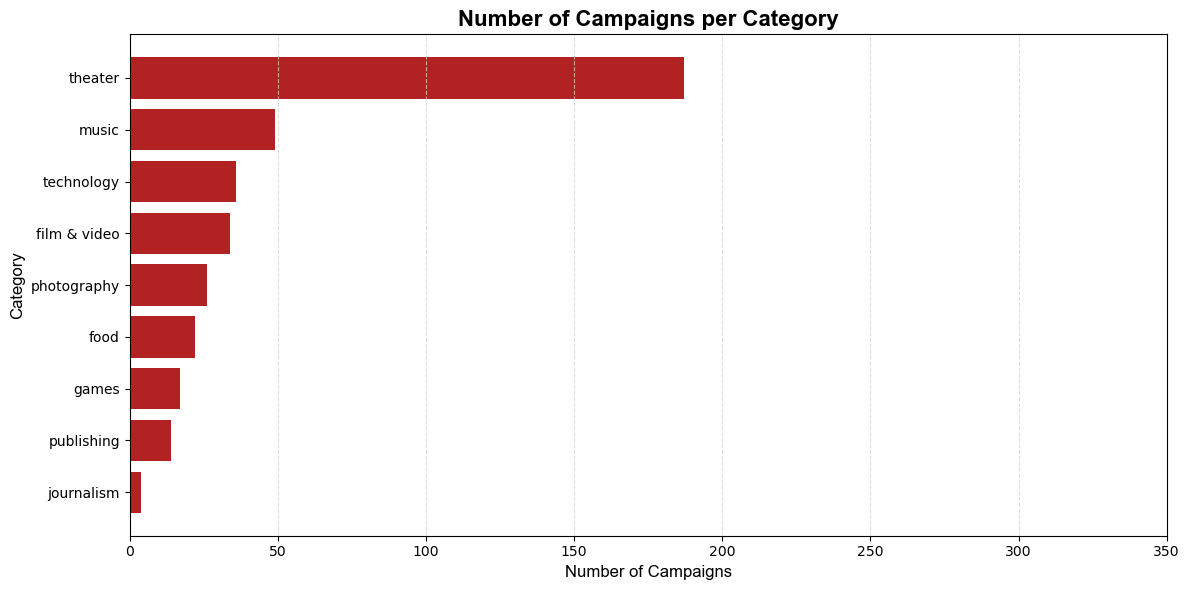

In [27]:
# Change Canvas Size
plt.figure(figsize=(12, 6))

# Create a basic plot
plt.barh(df1.category, df1.num_campaigns, color="firebrick", align="center")

# Customizations

# Change colors
# Add in reference lines
# Add Labels/Title
plt.xlabel("Number of Campaigns", fontfamily="Arial", fontsize=12)
plt.ylabel("Category", fontfamily="Arial", fontsize=12)
plt.title("Number of Campaigns per Category", fontweight="bold", fontsize=16, fontfamily="Arial")

# Set X/Y Limits
plt.xlim(0, 350)

# Add in a background grid
plt.grid(axis="x", linestyle="--", color="lightgrey", alpha=0.75)

# Invert the Y-axis to have the biggest bar on top
plt.gca().invert_yaxis()

# Show/Save the Graph
plt.tight_layout()
plt.savefig("part4_categories.png")
plt.show()

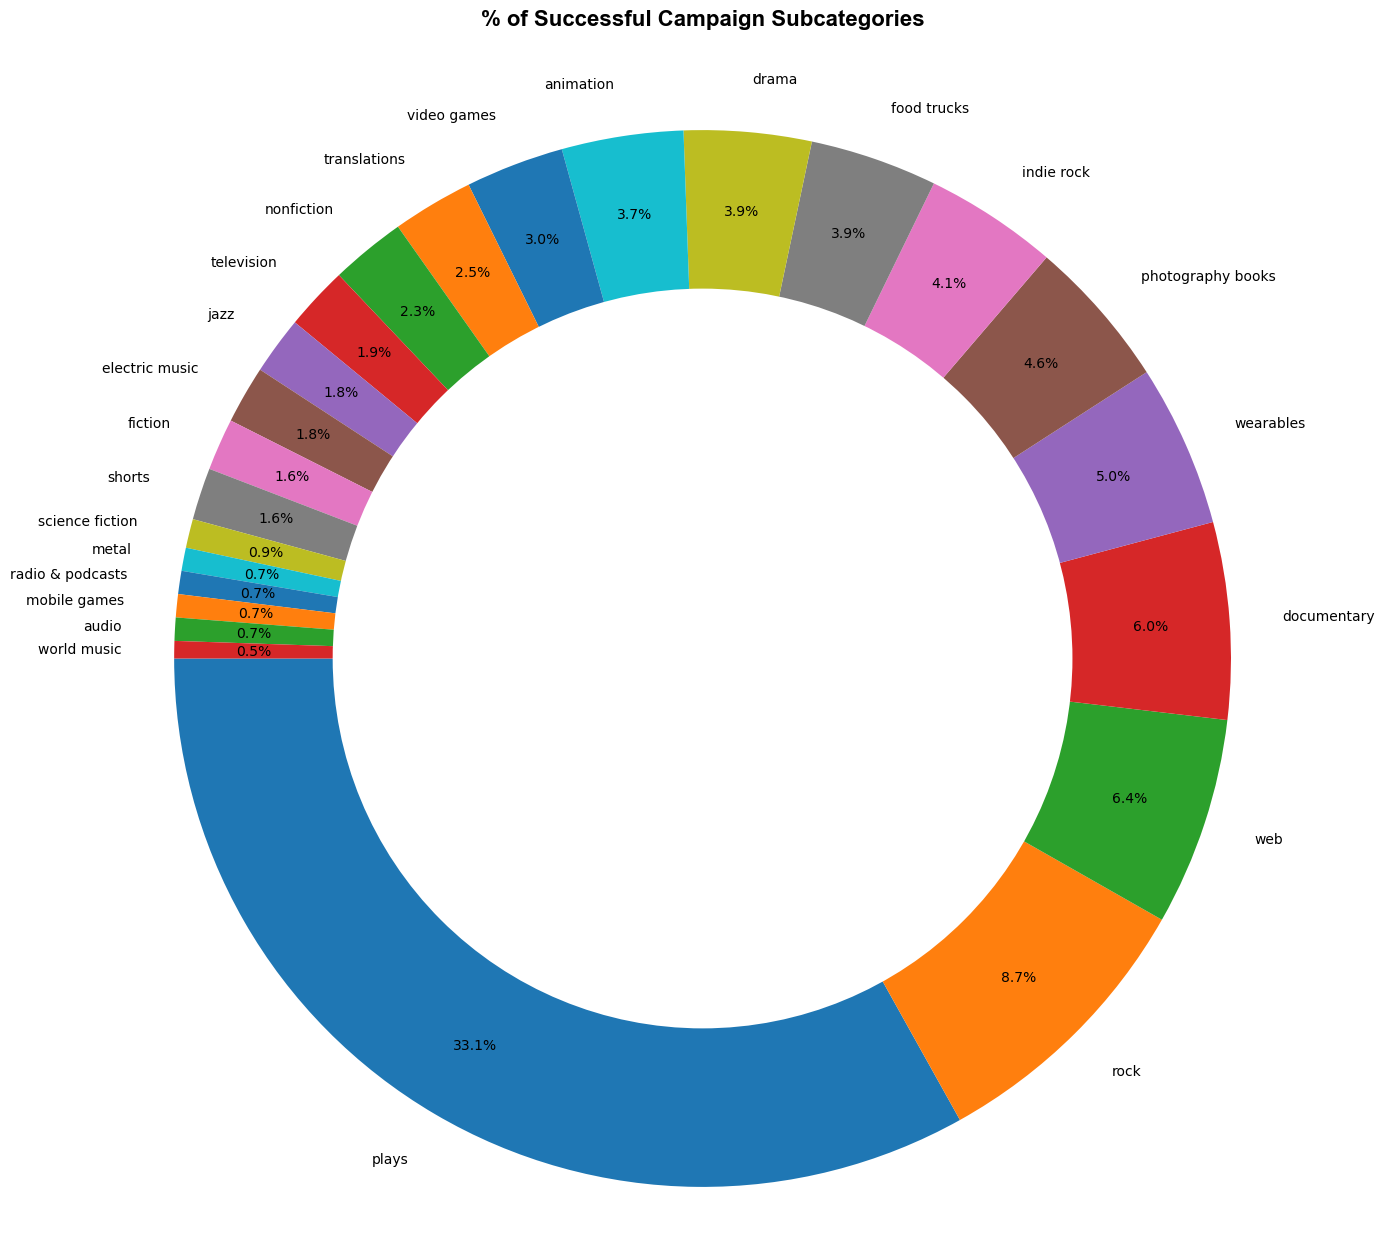

In [28]:
# Change Canvas Size
plt.figure(figsize=(15, 15))

# Create a donut chart
plt.pie(df1.num_campaigns, labels=df1.subcategory, autopct="%1.1f%%", shadow=False, startangle=180, pctdistance=0.85)

#Customizations

# Change colors
# Add in reference lines
# Add Labels/Title
centre_circle = plt.Circle((0,0), 0.70, fc='white')  # Adjust 0.70 for hole size
plt.gca().add_artist(centre_circle)
plt.title(f"% of Successful Campaign Subcategories", fontweight="bold", fontsize=16, fontfamily="Arial", pad = 40)
plt.axis("equal")

# Show/Save the Graph
plt.savefig("part2_categories.png")
plt.show()

In [30]:
engine.dispose()